## LSTM Autoencoders
Autoencoders Neural Networks try to learn data representation of its input. So the input of the Autoencoder is the same as the output? Not quite. Usually, we want to learn an efficient encoding that uses fewer parameters/memory.

The encoding should allow for output similar to the original input. In a sense, we’re forcing the model to learn the most important features of the data using as few parameters as possible.

## Anomaly Detection with Autoencoders
Here are the basic steps to Anomaly Detection using an Autoencoder:

### Train an Autoencoder on normal data (no anomalies)
### Take a new data point and try to reconstruct it using the Autoencoder
### If the error (reconstruction error) for the new data point is above some threshold, we label the example as an anomaly
Good, but is this useful for Time Series Data? Yes, we need to take into account the temporal properties of the data. Luckily, LSTMs can help us with that.

S&P 500 Index Data
Our data is the daily closing prices for the S&P 500 index from 1986 to 2018.

The S&P 500, or just the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market. -Wikipedia

It is provided by Patrick David and hosted on Kaggle. The data contains only two columns/features - the date and the closing price. Let’s download and load into a Data Frame:

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [2]:
# This training set takes 95% of earlier data and the test data is the last 5%
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)
train.head()

(7782, 1) (410, 1)


,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [3]:
from sklearn.preprocessing import StandardScaler
def scale(X_train, X_test):    
    scaler = StandardScaler()
    scaler = scaler.fit(X_train.values)
    train = scaler.transform(X_train.values)    
    test = scaler.transform(X_test.values)
    df_X_train = pd.DataFrame(train, columns=X_train.columns)
    df_X_test = pd.DataFrame(test, columns=X_test.columns)    
    return df_X_train, df_X_test

train, test = scale(train, test)
train

,close
0,-1.475126
1,-1.472703
2,-1.473135
3,-1.467219
4,-1.478169
...,...
7777,2.047774
7778,2.134814
7779,2.149916
7780,2.194431


In [4]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [5]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)

X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)

print(X_train.shape)

(7752, 30, 1)


LSTM Autoencoder in Keras
Our Autoencoder should take a sequence as input and outputs a sequence of the same shape. Here’s how to build such a simple model in Keras:

In [6]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam')

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-20 20:47:03.419179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-20 20:47:03.419266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


There are a couple of things that might be new to you in this model. The RepeatVector layer simply repeats the input n times. Adding return_sequences=True in LSTM layer makes it return the sequence.

Finally, the TimeDistributed layer creates a vector with a length of the number of outputs from the previous layer. Your first LSTM Autoencoder is ready for training.

Training the model is no different from a regular LSTM model:

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

2022-10-20 20:47:03.648189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-20 20:47:03.648374: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-10-20 20:47:04.198006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-20 20:47:04.347523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-20 20:47:04.440561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-20 20:47:04.552415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  3/218 [..............................] - ETA: 6s - loss: 1.2988  

2022-10-20 20:47:04.732022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


217/218 [============================>.] - ETA: 0s - loss: 0.1662

2022-10-20 20:47:10.910682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-20 20:47:10.966817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-20 20:47:11.032964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 8s 30ms/step - loss: 0.1662 - val_loss: 0.1815
Epoch 2/10
218/218 [==============================] - 6s 29ms/step - loss: 0.0759 - val_loss: 0.2720
Epoch 3/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0537 - val_loss: 0.2354
Epoch 4/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0550 - val_loss: 0.2194
Epoch 5/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0487 - val_loss: 0.1962
Epoch 6/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0472 - val_loss: 0.1611
Epoch 7/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0422 - val_loss: 0.1825
Epoch 8/10
218/218 [==============================] - 6s 29ms/step - loss: 0.0430 - val_loss: 0.1559
Epoch 9/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0376 - val_loss: 0.1765
Epoch 10/10
218/218 [==============================] - 6s 28ms/step - loss: 0.0382 - val_loss: 0.1567


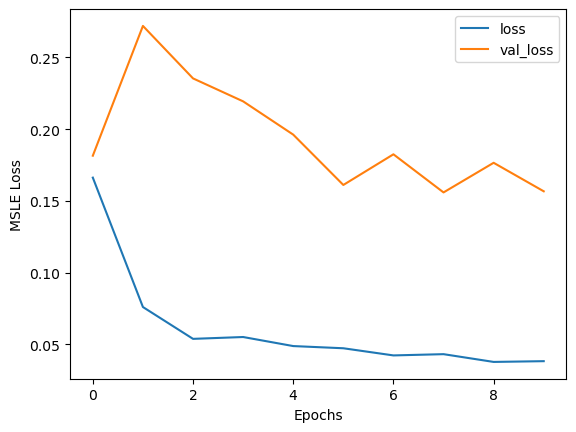

In [8]:
from matplotlib import pyplot as plt 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [9]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

2022-10-20 20:48:07.427229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-20 20:48:07.475611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-20 20:48:07.543915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


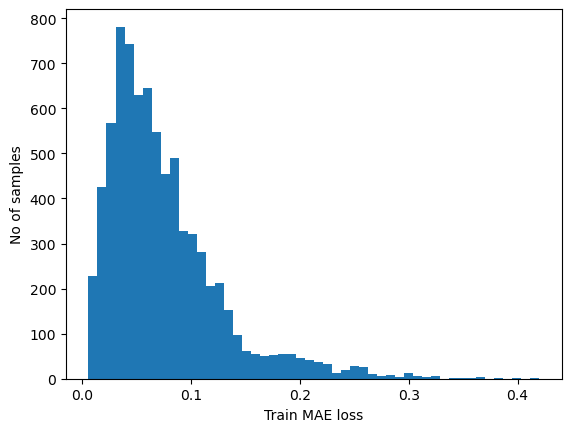

In [10]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

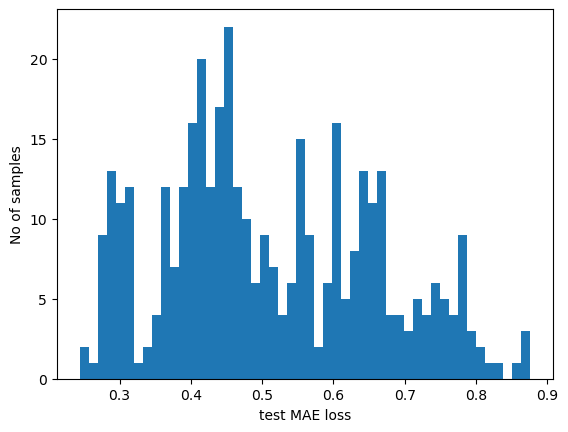

In [14]:
# We’ll pick a threshold of 0.65, as not much of the loss is larger than that. When the error is larger than that, we’ll declare that example an anomaly:
THRESHOLD = 0.65
# calc MAE on test data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [15]:
# We’ll build a DataFrame containing the loss and the anomalies (values above the threshold):
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,close
305,0.656027,0.65,True,3.435135
306,0.672940,0.65,True,3.431698
307,0.686633,0.65,True,3.319282
308,0.718965,0.65,True,3.106679
309,0.781395,0.65,True,3.193456
...,...,...,...,...
405,0.720457,0.65,True,3.234646
406,0.737082,0.65,True,3.245897
407,0.744951,0.65,True,3.201889
408,0.758562,0.65,True,3.233219


In [16]:
print("Number of anomaly samples: ", len(anomalies))
print("Indices of anomaly samples: ", np.array(anomalies.index))

Number of anomaly samples:  76
Indices of anomaly samples:  [305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 361 362 363 364 365 387 388 389 390 398 399 400 401 402 403 404 405
 406 407 408 409]


You should have a thorough look at the chart. The red dots (anomalies) are covering most of the points with abrupt changes to the closing price. You can play around with the threshold and try to get even better results. You just combined two powerful concepts in Deep Learning - LSTMs and Autoencoders. The result is a model that can find anomalies in S&P 500 closing price data. You can try to tune the model and/or the threshold to get even better results.